In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import shuffle

![data_visualization_3](./images/37_page.jpg)

![data_visualization_3](./images/38_page.jpg)

# Model evaluation

Be the algorithm
- solve manually
- if you can't, can you expect a machine too?

Look at the samples you get wrong
- best, worst, uncertain (50% probability in classification)

## Train / test / validation / holdout

### Train

- used to find statistics & parameters of a model

### Validation

- aka test
- used to find hyperparameters & select a model
- should both be representative of new/future data

### Holdout

- aka test
- how well did my final model do
- should be representative of new/future data
- use a test set to evaluate the performance of the model selected using the previous steps

## Metrics

Align with a business objective / product
- possible to have a good ML model with a bad product

Most are **aggregates**
- lose/hide infomation

### Classification metrics

BLUE, cross entropy
- key question = can I take a gradient?

Zero one loss 
- hard to optimize

**Always look at class cardinality & imbalance**
- more classes = harder problem
- imbalance = easier (can predict most common class & do well)

### Accuracy
- correct / all predictions
- not useful with strong imbalance
- LOC 2390 of building ml powered

### Confusion matrix

![tp_fp](./images/tp_fp.png)

|  | 0 | 1 |
| --- | --- | --- |
| 0| tn | fn |
| 1| fp | tp |


### Precision
- tp / (tp + fp)
- how many positive predictions were correct
- false detection
- fraction of all predictions of class 1 that are correct
- minimize false positives

### Recall
- tp / (tp + fn)
- how many positives did I detect out of all the positives
- misses
- how many of the true class 1 did I predict

**Note that only one term changes in the definitions of precision & recall!**
- whether you are dealing with fp (precision) or fn (recall)

Always tradeoff between precision & recall

Predicitive maintenance
- false positives = ok, false negatives = not ok

## True / false positive rates

Measuring p with r = nonsense
- can maximize one at the cost of the other

F1

Area under ROC
- 1 = perfect, 0.5 = random
- use for classifiers that can modify a threshold
- summarizes tradeoffs in varying the threshold
- what does under the line of ROC mean?

Threshold tuning

Average precision
- averaged over all recalls

Create an imbalanced dataset, by selecting only the sevens:

In [2]:

data = load_digits()

y = data.target
x = data.data / 255

noise = np.random.random(size=x.size).reshape(x.shape)
x += noise * 0.5
y = (y == 3).astype(int)

In [3]:
np.mean(y)

0.1018363939899833

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')

model.fit(x, y)

probs = model.decision_function(x)

In [5]:
probs

array([-2.82430331, -2.81728529, -1.53751457, ..., -1.72888893,
       -2.70199945, -0.98112257])

0.711205232900644


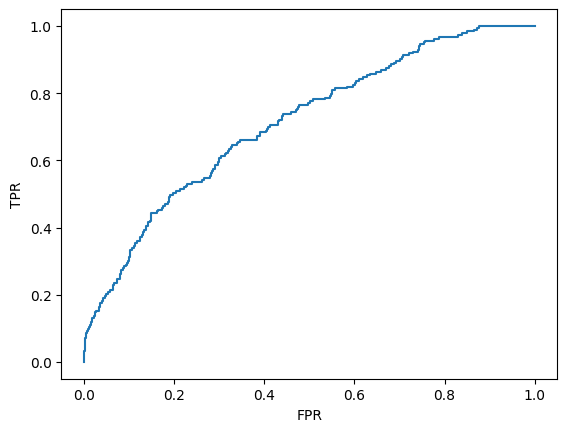

In [6]:
fpr, tpr, thresholds = roc_curve(y, probs)

roc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print(roc)

### Regression metrics

MAE

MSE

RMSE

MAPE

MASE

MAPE is not symmetric
- puts a heavier penalty on negative errors

In [7]:
def mape(pred, act):
    return abs((pred - act) / act)

In [8]:
print(mape(100, 90))
print(mape(100, 110))

0.1111111111111111
0.09090909090909091


In [9]:
import sys
sys.path.append('..')

from common import load_iris

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB

## Splitting datasets (train or validation)

Be careful with random sampling of datasets - **data leakage**
- predicting the past from the future
- duplicates

In [10]:
ds = load_iris()

x, y = ds.features, ds.target

y = pd.DataFrame(data=np.argmax(y.values, axis=1), index=y.index)

The Iris dataset was used in R.A. Fisher's classic 1936 paper *The Use of Multiple Measurements in Taxonomic Problems*.

features.shape = (150, 4)
target.shape = (150, 3)


## Test set

Let's follow a best practice and split off a test set.  Reason for this is:
- unseen data for a final measure of generalization error
- only ever do one forward pass on this dataset

In [11]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.1)
assert x_tr.shape[0] > x_te.shape[0]

## Cross-validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

https://scikit-learn.org/stable/modules/naive_bayes.html

CV
- use for hyperparams
- use all your data for test & train
- large K = small test set sizes
- computationally expensive
- avoid fitting your test set

When not to randomly sample
- time series

Cross validation = randomly sample!
- see [sklearn.model_selection.TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

Pick a model and do cross-validation.  Reasons for this:
- use all data
- don't overfit holdout set

In [12]:
model = GaussianNB(priors=[1/3 for _ in range(3)])

#  defaults to stratified KFold
results = cross_validate(
    model, 
    x_tr, 
    y_tr.values.flatten(), 
    scoring='accuracy', 
    cv=5,
    return_train_score=True
)

In [13]:
pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001891,0.001067,0.888889,0.972222
1,0.001450,0.001112,0.888889,0.972222
2,0.001387,0.000657,1.000000,0.944444
3,0.001019,0.000649,0.962963,0.962963
4,0.001044,0.000661,1.000000,0.944444


## Grid search + cross-validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Most of the time these occur together

In [14]:
from sklearn.model_selection import GridSearchCV

def make_prior(logits):
    s = sum(logits)
    return [e / s for e in logits]

params = {
    'n_estimators': [1, 10, 100],
    'max_features': [1, 2, 3]
}

model = RandomForestClassifier()

gs = GridSearchCV(model, params, cv=5, return_train_score=True)
gs.fit(x_tr, y_tr.values.reshape(-1, ))

res = gs.cv_results_
print(res.keys())

res = pd.DataFrame(res)

cols = [r for r in res.columns if ('score' in r and 'mean' in r)]

print(np.max(res.loc[:, 'mean_test_score']))
res.loc[:, cols]

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
0.962962962962963


,mean_score_time,mean_test_score,mean_train_score
0,0.000931,0.896296,0.962963
1,0.001433,0.962963,0.998148
2,0.005503,0.955556,1.000000
3,0.000867,0.940741,0.970370
4,0.001349,0.940741,0.988889
5,0.005808,0.955556,1.000000
6,0.000723,0.940741,0.975926
7,0.001387,0.940741,0.988889
8,0.005546,0.955556,0.998148


## Random search + cross-validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Random search is better (so they say)

In [15]:
from sklearn.model_selection import RandomizedSearchCV

import scipy.stats as stats

params = {
    'n_estimators': stats.randint(10, 1000),
    'max_features': stats.randint(1, 3),
    'max_depth': stats.randint(1, 30)
}

model = RandomForestClassifier()

rs = RandomizedSearchCV(model, params, cv=5, return_train_score=True, n_iter=32)
rs.fit(x_tr, y_tr.values.reshape(-1, ))

res = rs.cv_results_
res = pd.DataFrame(res)
cols = [r for r in res.columns if ('score' in r and 'mean' in r)]
print(np.max(res.loc[:, 'mean_test_score']))
res.loc[:, cols]

0.9555555555555555


,mean_score_time,mean_test_score,mean_train_score
0,0.009247,0.955556,1.000000
1,0.046543,0.948148,0.955556
2,0.044019,0.955556,1.000000
3,0.020088,0.948148,0.992593
4,0.017243,0.955556,1.000000
5,0.017543,0.948148,1.000000
6,0.041597,0.955556,1.000000
7,0.007828,0.955556,1.000000
8,0.010267,0.955556,0.985185
9,0.008764,0.955556,1.000000


## A closer look at cross-validation

In [16]:
import sys
sys.path.append('..')
from common import load_forest_fires

In [17]:
forest = load_forest_fires()

For more information, read [Cortez and Morais, 2007].
        1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
        2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
        3. month - month of the year: 'jan' to 'dec'
        4. day - day of the week: 'mon' to 'sun'
        5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
        6. DMC - DMC index from the FWI system: 1.1 to 291.3
        7. DC - DC index from the FWI system: 7.9 to 860.6
        8. ISI - ISI index from the FWI system: 0.0 to 56.10
        9. temp - temperature in Celsius degrees: 2.2 to 33.30
        10. RH - relative humidity in %: 15.0 to 100
        11. wind - wind speed in km/h: 0.40 to 9.40
        12. rain - outside rain in mm/m2 : 0.0 to 6.4
        13. area - the burned area of the forest (in ha): 0.00 to 1090.84
    (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).')

data.shape = (517, 

In [18]:
model = RandomForestRegressor(n_estimators=50)

x = forest.loc[:, ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
y = forest.loc[:, 'area']

from sklearn.metrics import mean_absolute_error

res = []
for _ in range(10):
    x, y = shuffle(x, y)
    
    results = cross_validate(
        model, 
        x, 
        y.values.flatten(), 
        scoring='neg_mean_absolute_error',
        cv=3,
        return_train_score=True
    )

    res.append(results['test_score'])
 
res = pd.DataFrame(res)
res.loc[:, 'avg'] = res.loc[:, :].mean(axis=1)
res

,0,1,2,avg
0,-22.414666,-24.572178,-20.371165,-22.452670
1,-27.653923,-15.691591,-26.360487,-23.235334
2,-16.228391,-23.401557,-24.614218,-21.414722
3,-25.929933,-14.752233,-18.154333,-19.612166
4,-17.174118,-25.194745,-19.444706,-20.604523
5,-15.768371,-20.029562,-26.712386,-20.836773
6,-20.465942,-26.145970,-15.475687,-20.695867
7,-18.820809,-25.372250,-22.689405,-22.294155
8,-25.536296,-18.676131,-23.915044,-22.709157
9,-23.221134,-22.611430,-17.327822,-21.053462


In [19]:
res.min().min() ,res.max().max()

(-27.653923457197905, -14.752233117386488)

This noise is unavoidable!

## References

[How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

[Understanding and diagnosing your machine-learning models - Gaël Varoquaux](https://www.youtube.com/watch?v=kbj3llSbaVA)